In [22]:
%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [23]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

In [24]:
with open("./saved_detections/ball_detections.pkl", "rb") as file:
    ball_detections = pickle.load(file)

ball_detections = [position.get(1, []) for position in ball_detections]
ball_detections_df = pd.DataFrame(ball_detections, columns=["x1", "y1", "x2", "y2"])
ball_detections_df = ball_detections_df.interpolate()
ball_detections_df = ball_detections_df.bfill()

ball_detections_df

,x1,y1,x2,y2
0,391.750336,235.203003,399.010834,242.693176
1,395.390015,233.110229,401.882935,239.377594
2,399.668365,230.332092,405.861745,236.562113
3,403.946716,227.553955,409.840556,233.746633
4,408.225067,224.775818,413.819366,230.931152
...,...,...,...,...
529,231.359985,131.100891,237.080811,137.334869
530,227.764175,124.969521,233.067642,130.902794
531,224.168365,118.838150,229.054474,124.470718
532,220.091965,113.170959,225.825668,119.420685


In [25]:
window = 5
min_period = 1
is_centered = False

ball_detections_df["x_avg_raw"] = (
    ball_detections_df["x1"] + ball_detections_df["x2"]
) / 2
ball_detections_df["y_avg_raw"] = (
    ball_detections_df["y1"] + ball_detections_df["y2"]
) / 2

ball_detections_df["x_avg"] = (
    ball_detections_df["x_avg_raw"]
    .rolling(window=window, min_periods=min_period, center=is_centered)
    .mean()
)
ball_detections_df["y_avg"] = (
    ball_detections_df["y_avg_raw"]
    .rolling(window=window, min_periods=min_period, center=is_centered)
    .mean()
)

ball_detections_df

,x1,y1,x2,y2,x_avg_raw,y_avg_raw,x_avg,y_avg
0,391.750336,235.203003,399.010834,242.693176,395.380585,238.948090,395.380585,238.948090
1,395.390015,233.110229,401.882935,239.377594,398.636475,236.243912,397.008530,237.596001
2,399.668365,230.332092,405.861745,236.562113,402.765055,233.447103,398.927372,236.213035
3,403.946716,227.553955,409.840556,233.746633,406.893636,230.650294,400.918938,234.822350
4,408.225067,224.775818,413.819366,230.931152,411.022217,227.853485,402.939594,233.428577
...,...,...,...,...,...,...,...,...
529,231.359985,131.100891,237.080811,137.334869,234.220398,134.217880,245.107706,136.565434
530,227.764175,124.969521,233.067642,130.902794,230.415909,127.936157,239.810028,134.758476
531,224.168365,118.838150,229.054474,124.470718,226.611420,121.654434,235.068707,131.601912
532,220.091965,113.170959,225.825668,119.420685,222.958817,116.295822,230.729056,127.248790


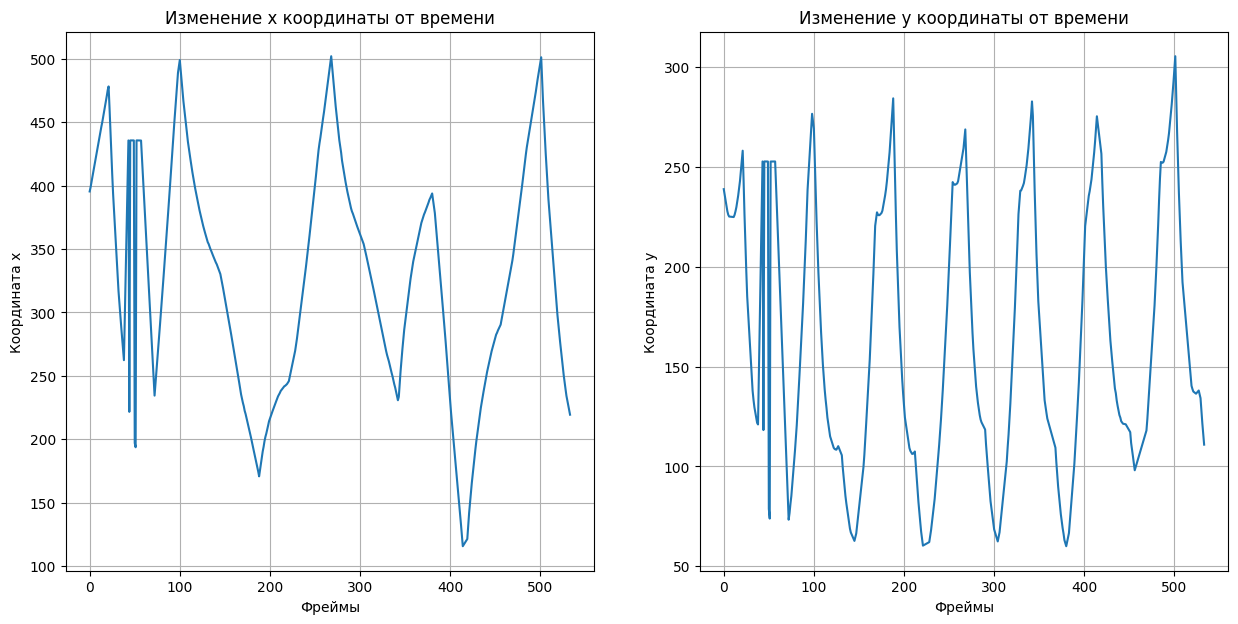

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

ax[0].plot(ball_detections_df["x_avg_raw"])
ax[0].set_title("Изменение x координаты от времени")
ax[0].set_xlabel("Фреймы")
ax[0].set_ylabel("Координата x")
ax[0].grid()

ax[1].plot(ball_detections_df["y_avg_raw"])
ax[1].set_title("Изменение y координаты от времени")
ax[1].set_xlabel("Фреймы")
ax[1].set_ylabel("Координата y")
ax[1].grid()

plt.show()

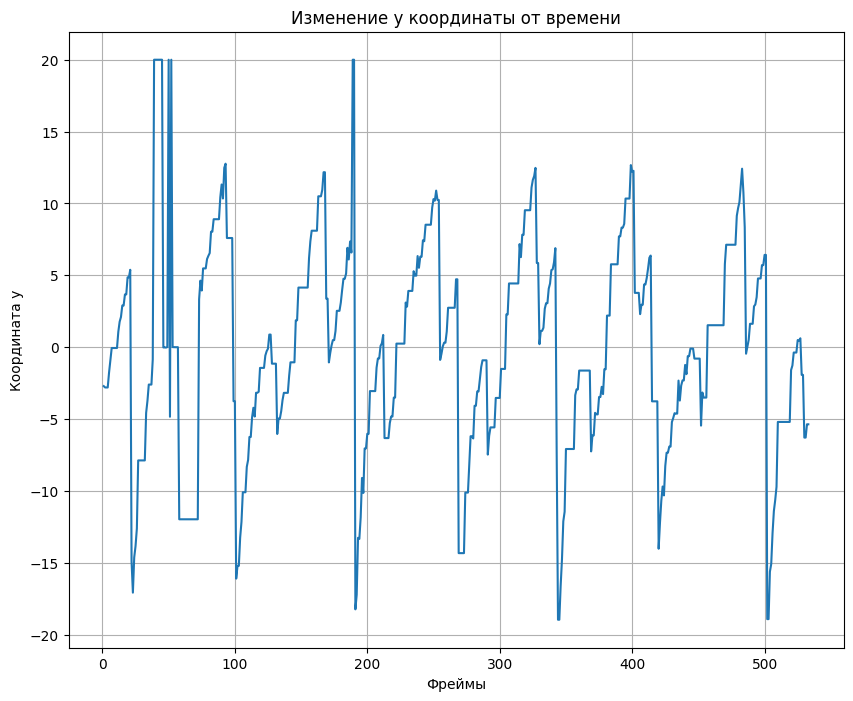

In [27]:
# По координате y можно понять, когда мяч был ударен ракеткой
ball_detections_df["y_delta"] = ball_detections_df["y_avg_raw"].diff()
ball_detections_df["y_delta"] = ball_detections_df["y_delta"].apply(
    lambda x: 20 if abs(x) > 20 else x
)

plt.figure(figsize=(10, 8))
plt.plot(ball_detections_df["y_delta"])
plt.title("Изменение y координаты от времени")
plt.xlabel("Фреймы")
plt.ylabel("Координата y")
plt.grid()
plt.show()

In [28]:
def changes_detector(start, end):
    negative_change = False
    positive_change = False

    if (
        ball_detections_df["y_delta"].iloc[start] > 0
        and ball_detections_df["y_delta"].iloc[end] < 0
    ):
        negative_change = True
    if (
        ball_detections_df["y_delta"].iloc[start] < 0
        and ball_detections_df["y_delta"].iloc[end] > 0
    ):
        positive_change = True

    return negative_change, positive_change

In [29]:
window_change_frames = 25
buffer = int(window_change_frames * 1.1)

ball_detections_df["is_hit"] = 0
ball_detections_df["hits"] = 0
for i in range(1, len(ball_detections_df) - buffer):
    negative_change, positive_change = changes_detector(i, i + 1)

    if negative_change or positive_change:
        monotonicity_counter = 0

        for j in range(i + 1, i + buffer + 1):
            negative_following_change, positive_following_change = changes_detector(
                i, j
            )
            if negative_following_change and negative_change:
                monotonicity_counter += 1
            elif positive_following_change and positive_change:
                monotonicity_counter += 1

        if window_change_frames <= monotonicity_counter:
            ball_detections_df["hits"].iloc[i:] += 1
            ball_detections_df["is_hit"].iloc[i] = 1

ball_detections_df

,x1,y1,x2,y2,x_avg_raw,y_avg_raw,x_avg,y_avg,y_delta,is_hit,hits
0,391.750336,235.203003,399.010834,242.693176,395.380585,238.948090,395.380585,238.948090,NaN,0,0
1,395.390015,233.110229,401.882935,239.377594,398.636475,236.243912,397.008530,237.596001,-2.704178,0,0
2,399.668365,230.332092,405.861745,236.562113,402.765055,233.447103,398.927372,236.213035,-2.796809,0,0
3,403.946716,227.553955,409.840556,233.746633,406.893636,230.650294,400.918938,234.822350,-2.796809,0,0
4,408.225067,224.775818,413.819366,230.931152,411.022217,227.853485,402.939594,233.428577,-2.796809,0,0
...,...,...,...,...,...,...,...,...,...,...,...
529,231.359985,131.100891,237.080811,137.334869,234.220398,134.217880,245.107706,136.565434,-1.921776,0,10
530,227.764175,124.969521,233.067642,130.902794,230.415909,127.936157,239.810028,134.758476,-6.281723,0,10
531,224.168365,118.838150,229.054474,124.470718,226.611420,121.654434,235.068707,131.601912,-6.281723,0,10
532,220.091965,113.170959,225.825668,119.420685,222.958817,116.295822,230.729056,127.248790,-5.358612,0,10


In [30]:
ball_detections_df[ball_detections_df["is_hit"] == 1].index.tolist()

[72, 98, 145, 221, 268, 304, 342, 380, 414, 456]

In [31]:
stats = pd.read_csv("./output/game_stats.csv", sep=",")
stats

,frame_num,frame,player_1_hits,player_1_total_b_speed,player_1_last_b_speed,player_1_total_speed,player_1_last_speed,player_2_hits,player_2_total_b_speed,player_2_last_b_speed,player_2_total_speed,player_2_last_speed,player_1_average_shot_speed,player_2_average_shot_speed,player_1_average_player_speed,player_2_average_player_speed
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,529,0.0,5.0,244.852448,60.771271,21.677675,2.941239,4.0,201.764069,50.556389,37.137615,3.276578,48.97049,50.441017,4.335535,9.284404
530,530,0.0,5.0,244.852448,60.771271,21.677675,2.941239,4.0,201.764069,50.556389,37.137615,3.276578,48.97049,50.441017,4.335535,9.284404
531,531,0.0,5.0,244.852448,60.771271,21.677675,2.941239,4.0,201.764069,50.556389,37.137615,3.276578,48.97049,50.441017,4.335535,9.284404
532,532,0.0,5.0,244.852448,60.771271,21.677675,2.941239,4.0,201.764069,50.556389,37.137615,3.276578,48.97049,50.441017,4.335535,9.284404
